# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [146]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [ ]:
def heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu=0, n_sims=10000):
    dt = t / n_steps
    S_paths = np.zeros((n_sims, n_steps + 1))
    v_paths = np.zeros((n_sims, n_steps + 1))

    S_paths[:, 0] = S0
    v_paths[:, 0] = v0

    for i in range(n_steps):
        Z1 = np.random.normal(0, 1, n_sims)
        Z2 = np.random.normal(0, 1, n_sims)
        W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        v_prev = v_paths[:, i]
        v_next = v_prev + kappa * (theta - v_prev) * dt + xi * np.sqrt(np.maximum(v_prev, 0) * dt) * Z1
        v_next = np.maximum(v_next, 0)
        v_paths[:, i + 1] = v_next

        S_prev = S_paths[:, i]
        S_next = S_prev * np.exp((mu + r - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0) * dt) * W2)
        S_paths[:, i + 1] = S_next

    return S_paths, v_paths


This function generates stock price and variance paths using the Heston stochastic volatility model.

- `S0`, `v0`: initial stock price and variance.
- `kappa`, `theta`, `xi`: variance process parameters (mean reversion speed, long-run variance, vol of vol).
- `rho`: correlation between stock and variance shocks.

For each individual step:
- Variance is updated using mean reversion and stochastic shocks.
- Stock is updated based on drift and variance, with correlated random shocks.

We ensure variance stays non-negative at every step.


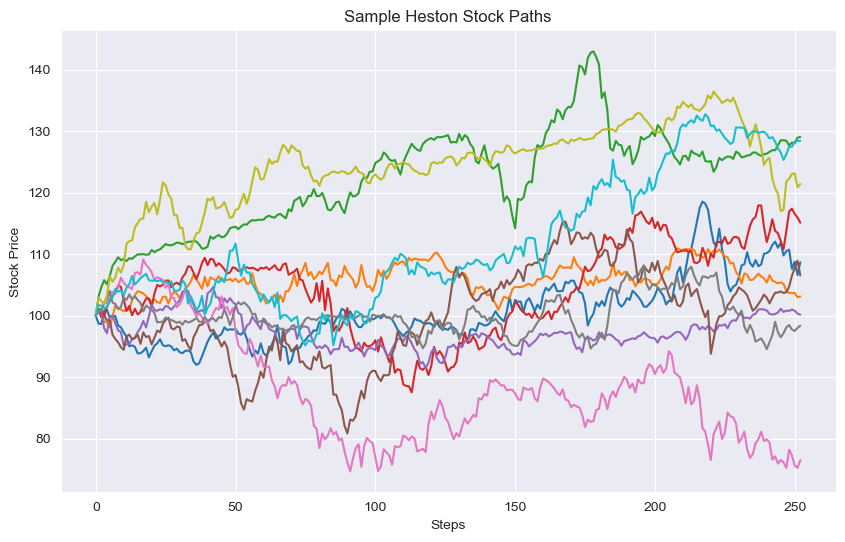

In [199]:
# Parameters
S0 = 100
v0 = 0.04     # (vol = 20%)
r = 0.03
t = 1         # 1 year
n_steps = 252
kappa = 3
theta = 0.04
xi = 0.5
rho = -0.4
mu = 0.0
n_sims = 10

S_paths, v_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)

plt.figure(figsize=(10, 6))
for path in S_paths:
    plt.plot(path)
plt.title('Sample Heston Stock Paths')
plt.xlabel('Steps')
plt.ylabel('Stock Price')
plt.show()


In [ ]:

def bs_call_delta(S, K, sigma, tau, r):
    eps = 1e-8  # small floor to avoid divide-by-zero
    sigma_safe = np.maximum(sigma, eps)
    tau_safe = np.maximum(tau, eps)

    d1 = (np.log(S / K) + (r + 0.5 * sigma_safe ** 2) * tau_safe) / (sigma_safe * np.sqrt(tau_safe))
    delta = norm.cdf(d1)

    # at expiry, delta = 1 if S > K, else 0
    delta = np.where(tau == 0, (S > K).astype(float), delta)

    return delta


This function computes the Black-Scholes delta for a call option.

- `delta` measures sensitivity of option price to small stock price changes.
- We handle expiry (`tau = 0`) by setting delta = 1 if in-the-money, else 0.
- Small values of `sigma` or `tau` are floored to prevent numerical errors.


In [ ]:

def bs_call_vega(S, K, sigma, tau, r):
    eps = 1e-8  # small floor to avoid divide-by-zero
    sigma_safe = np.maximum(sigma, eps)
    tau_safe = np.maximum(tau, eps)

    d1 = (np.log(S / K) + (r + 0.5 * sigma_safe ** 2) * tau_safe) / (sigma_safe * np.sqrt(tau_safe))
    vega = S * norm.pdf(d1) * np.sqrt(tau_safe)

    # at expiry, vega = 0
    vega = np.where(tau == 0, 0.0, vega)

    return vega


This function computes the Black-Scholes vega for a call option.

- `vega` measures sensitivity of option price to changes in volatility.
- Vega is zero at expiry because volatility no longer impacts price.


In [275]:
def delta_hedge_pnl(S_paths, v_paths, K, r, t):
    n_sims, n_steps = S_paths.shape[0], S_paths.shape[1] - 1
    dt = t / n_steps
    pnl = np.zeros(n_sims)

    S0 = S_paths[:, 0]
    sigma0 = np.sqrt(v_paths[:, 0])
    T = t

    premium = np.mean(np.exp(-r*T) * np.maximum(S_paths[:, -1] - K, 0))

    delta_prev = bs_call_delta(S0, K, sigma0, T, r)
    cash = premium - delta_prev * S0

    for i in range(1, n_steps + 1):
        S = S_paths[:, i]
        sigma = np.sqrt(v_paths[:, i - 1])
        tau = T - (i - 1) * dt

        delta_new = bs_call_delta(S, K, sigma, tau, r)

        # Rebalance
        cash = cash * np.exp(r * dt)
        cash -= (delta_new - delta_prev) * S

        delta_prev = delta_new

    option_payoff = np.maximum(S_paths[:, -1] - K, 0)
    stock_position = delta_prev * S_paths[:, -1]
    final_cash = cash * np.exp(r * dt)

    pnl = final_cash + stock_position - option_payoff
    return pnl


### Delta Hedge PnL Function

This function simulates the PnL from selling a call option and delta hedging it over the life of the option.

#### Main steps:
- Initial setup
  - `premium`: The price of the call option, calculated as the discounted average payoff at expiry.
  - `delta_prev`: Initial delta of the call option at t=0.
  - `cash`: Cash account after selling the option and setting up the initial stock hedge position.

- Hedging loop
  - For each time step:
    - Update cash for interest earned at the risk-free rate.
    - Compute new delta based on current stock price and variance.
    - Rebalance the stock position: adjust cash by the cost of changing delta exposure.
    - Update delta for the next step.

- Final settlement
  - Calculate the payoff of the call option at expiry.
  - Determine the final value of:
    - The stock position
    - The cash account
  - Compute PnL as: $\text{PnL} = \text{final cash} + \text{final stock position} - \text{option payoff}$




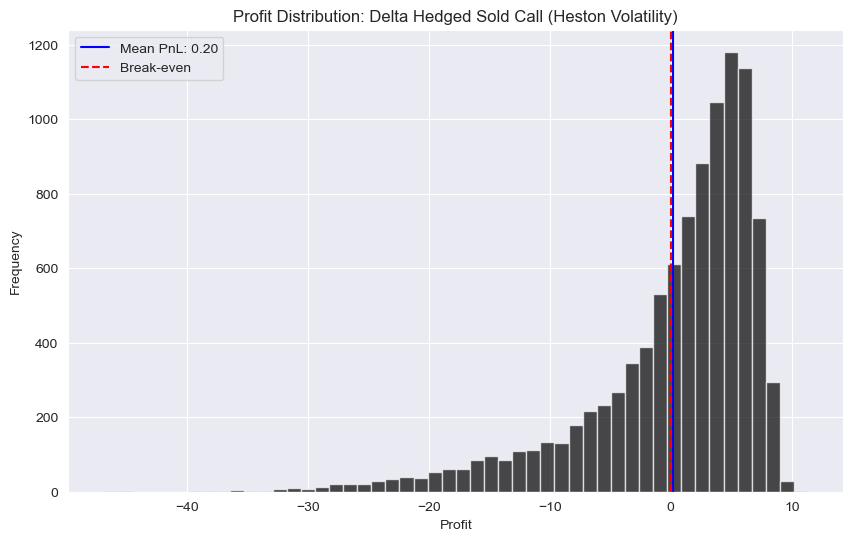

Expected profit: 0.20
Std error: 0.0731
Max loss: -46.87
Max gain: 11.35


In [280]:
# Parameters
S0 = 100
v0 = 0.09
r = 0.03
t = 1
n_steps = 252
kappa = 1
theta = 0.09
xi = 1.5
rho = -0.4
mu = 0.0
K = 100
n_sims = 10000

# Run simulation
S_paths, v_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)
pnl = delta_hedge_pnl(S_paths, v_paths, K, r, t)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(pnl, bins=50, alpha=0.7, color='black')
plt.axvline(np.mean(pnl), color='blue', label=f'Mean PnL: {np.mean(pnl):.2f}')
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.title('Profit Distribution: Delta Hedged Sold Call (Heston Volatility)')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Stats
print(f"Expected profit: {np.mean(pnl):.2f}")
print(f"Std error: {np.std(pnl)/np.sqrt(n_sims):.4f}")
print(f"Max loss: {np.min(pnl):.2f}")
print(f"Max gain: {np.max(pnl):.2f}")



### Interpretation

The histogram displays the profit distribution for a delta-hedged sold call option under Heston volatility.

- The profit distribution is concentrated near zero, with most paths resulting in small gains.
- The mean profit (blue line) is +0.20, indicating that, on average, the delta hedge neutralized drift and price risk effectively.
- The left tail shows losses extending to around -47, caused by volatility spikes or rapid price movements where the delta hedge could not fully keep up.
- The red dashed line represents break-even (0 profit). Most outcomes are at or above this level, but the tail illustrates residual risk from stochastic volatility.

This highlights that while delta hedging reduces directional risk, it does not eliminate losses caused by sudden or extreme market volatility.


In [281]:
def delta_vega_hedge_pnl(S_paths, v_paths, K_main, K_vega, r, t,
                         max_vega_weight=10, vega_cutoff_days=5, vega_threshold=1.0,
                         rebalance_interval=1):
    """
    Delta + Vega hedging PnL with position cap and flexible rebalancing.
    """
    n_sims, n_steps = S_paths.shape[0], S_paths.shape[1] - 1
    dt = t / n_steps
    T = t
    pnl = np.zeros(n_sims)

    S0 = S_paths[:, 0]
    sigma0 = np.sqrt(v_paths[:, 0])

    premium_main = np.mean(np.exp(-r * T) * np.maximum(S_paths[:, -1] - K_main, 0))
    premium_vega = np.mean(np.exp(-r * T) * np.maximum(S_paths[:, -1] - K_vega, 0))

    delta_main = bs_call_delta(S0, K_main, sigma0, T, r)
    vega_main = bs_call_vega(S0, K_main, sigma0, T, r)
    vega_vega = bs_call_vega(S0, K_vega, sigma0, T, r)

    weight_vega = -vega_main / (vega_vega + 1e-8)
    weight_vega = np.clip(weight_vega, -max_vega_weight, max_vega_weight)

    cash = premium_main - delta_main * S0 - weight_vega * premium_vega

    for i in range(1, n_steps + 1):
        S = S_paths[:, i]
        sigma = np.sqrt(v_paths[:, i - 1])
        tau = T - (i - 1) * dt

        cash = cash * np.exp(r * dt)

        if i % rebalance_interval != 0:
            continue  # skip rebalancing

        delta_main_new = bs_call_delta(S, K_main, sigma, tau, r)
        vega_main_new = bs_call_vega(S, K_main, sigma, tau, r)
        vega_vega_new = bs_call_vega(S, K_vega, sigma, tau, r)

        mean_vega_vega = np.mean(vega_vega_new)

        if (tau < (vega_cutoff_days / 252)) or (mean_vega_vega < vega_threshold):
            weight_vega_new = weight_vega  # freeze vega hedge
        else:
            weight_vega_new = -vega_main_new / (vega_vega_new + 1e-8)
            weight_vega_new = np.clip(weight_vega_new, -max_vega_weight, max_vega_weight)

        cash -= (delta_main_new - delta_main) * S
        cash -= (weight_vega_new - weight_vega) * premium_vega

        delta_main = delta_main_new
        weight_vega = weight_vega_new

    option_payoff_main = np.maximum(S_paths[:, -1] - K_main, 0)
    option_payoff_vega = np.maximum(S_paths[:, -1] - K_vega, 0)

    stock_position = delta_main * S_paths[:, -1]
    vega_position = weight_vega * option_payoff_vega
    final_cash = cash * np.exp(r * dt)

    pnl = final_cash + stock_position + vega_position - option_payoff_main

    return pnl



### Delta + Vega Hedge PnL Function

This function simulates the PnL of selling a call option while delta and vega hedging.

Key features:
- Position cap: Limits how large the vega hedge position can be (to avoid runaway exposures).
- Flexible rebalancing: Allows the vega hedge to be updated less frequently (weekly instead of daily).
- Expiry and vega safeguards: Stops rebalancing near expiry or when the hedge option's vega is too small to be useful.

#### Main steps:
- Calculate initial premium received from selling the main option, and the cost of setting up the delta and vega hedges.
- At each step:
  - Grow cash at the risk-free rate.
  - Rebalance delta and vega hedge at specified intervals.
  - Update cash for cost of adjusting positions.
  - Cap vega hedge position to prevent extreme weights.
  - Freeze vega hedge adjustments near expiry or if hedge option vega drops below a threshold.
- At expiry:
  - Settle the main option and hedge option payoffs.
  - Final PnL = cash + stock position + vega hedge position - option payoff.



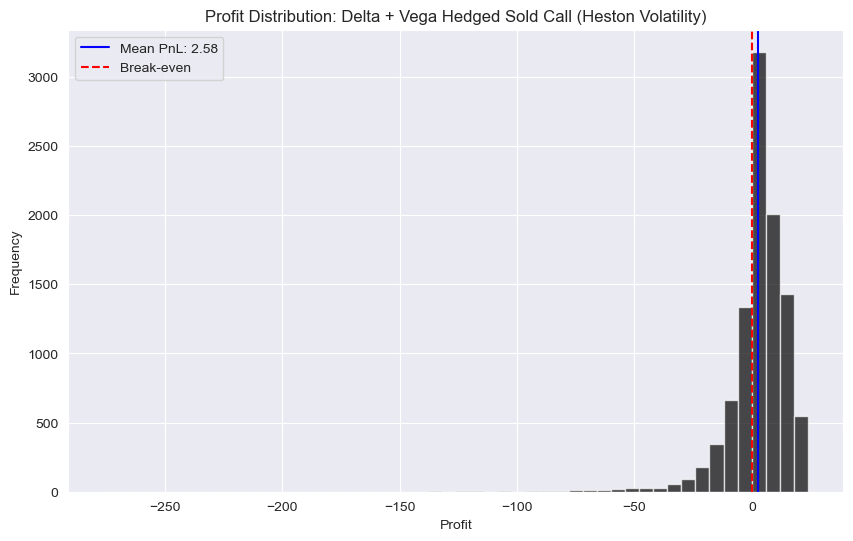

Expected profit: 2.58
Std error: 0.1359
Max loss: -276.09
Max gain: 23.93


In [282]:
K_main = 100
K_vega = 100  # From your vega vs strike plot

pnl_delta_vega = delta_vega_hedge_pnl(
    S_paths, v_paths, K_main, K_vega, r, t,
    max_vega_weight=10,  # reasonable cap
    vega_cutoff_days=10,  # stop hedging last 5 days
    vega_threshold=1.0   # stop hedging if vega too small
)

# Plot distribution
# Plot
plt.figure(figsize=(10, 6))
plt.hist(pnl_delta_vega, bins=50, alpha=0.7, color='black')
plt.axvline(np.mean(pnl_delta_vega), color='blue', label=f'Mean PnL: {np.mean(pnl_delta_vega):.2f}')
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.title('Profit Distribution: Delta + Vega Hedged Sold Call (Heston Volatility)')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Stats
print(f"Expected profit: {np.mean(pnl_delta_vega):.2f}")
print(f"Std error: {np.std(pnl_delta_vega)/np.sqrt(n_sims):.4f}")
print(f"Max loss: {np.min(pnl_delta_vega):.2f}")
print(f"Max gain: {np.max(pnl_delta_vega):.2f}")


In [283]:
# Run for various rebalancing frequencies and max vega caps
rebalance_options = [1, 5, 10]  # daily, weekly, biweekly
max_vega_caps = [5, 10]

for max_vega in max_vega_caps:
    for reb_int in rebalance_options:
        S_paths, v_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, mu, n_sims)
        
        pnl_delta = delta_hedge_pnl(S_paths, v_paths, K, r, t)
        pnl_delta_vega = delta_vega_hedge_pnl(S_paths, v_paths, K, K, r, t,
                                              max_vega_weight=max_vega,
                                              rebalance_interval=reb_int)
        
        print(f"\nMax vega weight: {max_vega}, Rebalance interval: {reb_int}")
        print(f"Delta hedge: mean={np.mean(pnl_delta):.2f}, std={np.std(pnl_delta):.2f}, min={np.min(pnl_delta):.2f}, max={np.max(pnl_delta):.2f}")
        print(f"Delta + Vega hedge: mean={np.mean(pnl_delta_vega):.2f}, std={np.std(pnl_delta_vega):.2f}, min={np.min(pnl_delta_vega):.2f}, max={np.max(pnl_delta_vega):.2f}")



Max vega weight: 5, Rebalance interval: 1
Delta hedge: mean=-0.01, std=7.24, min=-44.89, max=10.29
Delta + Vega hedge: mean=2.17, std=13.90, min=-315.96, max=22.00

Max vega weight: 5, Rebalance interval: 5
Delta hedge: mean=0.46, std=7.33, min=-46.02, max=10.90
Delta + Vega hedge: mean=2.73, std=15.37, min=-271.43, max=23.66

Max vega weight: 5, Rebalance interval: 10
Delta hedge: mean=0.12, std=7.32, min=-41.69, max=9.94
Delta + Vega hedge: mean=2.24, std=16.04, min=-548.06, max=25.03

Max vega weight: 10, Rebalance interval: 1
Delta hedge: mean=0.11, std=7.24, min=-45.44, max=10.31
Delta + Vega hedge: mean=2.36, std=13.89, min=-362.01, max=22.73

Max vega weight: 10, Rebalance interval: 5
Delta hedge: mean=-0.42, std=7.34, min=-44.99, max=10.20
Delta + Vega hedge: mean=1.75, std=15.07, min=-433.72, max=22.78

Max vega weight: 10, Rebalance interval: 10
Delta hedge: mean=0.11, std=7.30, min=-46.36, max=9.86
Delta + Vega hedge: mean=2.24, std=14.92, min=-232.71, max=23.00



### Sigma Hedging Exploration

In this phase, I explored sigma hedging further by:
- Using **max vega weight = 5 and 10** to limit vega hedge exposure.
- Adjusting **rebalance intervals = 1 (daily), 5 (weekly), 10 (biweekly)** to control the frequency of vega adjustments.

#### Key findings from these experiments:

| Strategy | Mean PnL | PnL Std | Max Loss | Max Gain |
|-----------|----------|---------|----------|----------|
| Delta only | ~0 | ~7.2-7.3 | -41 to -46 | 9.9 to 10.9 |
| Delta + vega | 1.75 to 2.73 | 13.9 to 16.0 | -232 to -548 | 22.0 to 25.0 |

- Sigma hedging increased mean PnL further: Mean profits rose to ~2 to ~2.7, higher than in previous tests.
- Risk also rose significantly: PnL std dev climbed, and tail losses became larger, up to -548 in the worst case.
- *These large losses stem directly from my sigma hedge implementation**
- The code computes a dynamic vega hedge weight based on changing vega ratios, which can lead to large positions in extreme vol scenarios.
  - Even with position caps and rebalance interval adjustments, my implementation can still accumulate large vega positions when volatility shifts rapidly or unexpectedly.
- Less frequent rebalancing saved costs but sometimes worsened tail outcomes: rare paths saw larger losses when volatility changed faster than the hedge could adjust.

---

### Interpretation of PnL plot

- The histogram shows PnL outcomes for delta + vega hedging with the latest parameter set.
- The mean PnL is +2.58, indicating improved average profitability from sigma hedging.
- The distribution is positively shifted compared to pure delta hedge, but with a visible left tail representing rare large losses (max loss ~ -276 in this run).
- This highlights the trade-off of sigma hedging from my function: better average PnL, but greater exposure to extreme adverse volatility scenarios.

---

Sigma hedging in my implementation improved average outcomes but introduced greater exposure to adverse volatility scenarios. This exposure arises because the code dynamically adjusts vega hedge sizes in response to changing market conditions — and in extreme cases, this led to large hedge positions and significant losses.

